In [5]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn as nn

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()
        self.features = nn.Sequential(
            # Bagian konvolusi / Ekstraksi Fitur
            nn.Conv2d(1, 32, kernel_size=(3,3), padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25),
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2), nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            # Bagian neural network
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))

In [7]:
model = MyCNN()
model.load_state_dict(torch.load("cnn_handsign_model.pth", map_location='cpu'))
model.eval()

C:\Users\gusti\AppData\Local\Temp\ipykernel_13600\2045912985.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_handsign_model.pth", m

MyCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(

In [13]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

In [ ]:
import cv2

drawing = False
ix, iy = -1, -1
x1, y1, x2, y2 = 0, 0, 0, 0
saved_img_count = 0
current_frame = None

def draw_rectangle(event, x, y, flags, param):
    global ix, iy, drawing, x1, y1, x2, y2
    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        ix, iy = x, y
    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            x1, y1, x2, y2 = ix, iy, x, y
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        x1, y1, x2, y2 = ix, iy, x, y

cap = cv2.VideoCapture(0)
cv2.namedWindow("Webcam")
cv2.setMouseCallback("Webcam", draw_rectangle)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    current_frame = frame.copy()

    # Gambar kotak crop
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2.imshow("Webcam", frame)

    key = cv2.waitKey(1) & 0xFF

    if key == ord('s'):  # Simpan crop area saat ini
        if current_frame is not None:
            roi = current_frame[min(y1,y2):max(y1,y2), min(x1,x2):max(x1,x2)]
            if roi.size != 0:
                filename = f"./result/cropped_{saved_img_count}.png"
                cv2.imwrite(filename, roi)
                print(f"Saved {filename}")
                saved_img_count += 1
            else:
                print("Area crop tidak valid, tidak disimpan.")
        else:
            print("Frame kosong, tidak bisa simpan.")

    elif key == ord('q'):  # Keluar program
        break

cap.release()
cv2.destroyAllWindows()


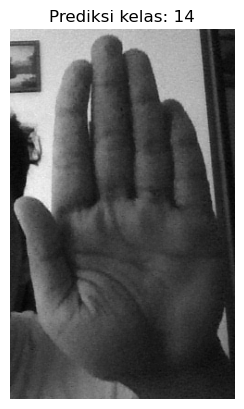

In [28]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# Load gambar dari file jpg
img_path = './result/cropped_0.png'
image = Image.open(img_path)
image = image.convert('L')  

# Preprocessing
input_tensor = transform(image).unsqueeze(0)  # tambah batch dimension [1, C, H, W]

# Inference
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)
    label = predicted.item()

plt.imshow(image.convert('L'), cmap='gray')  # pakai cmap gray kalau grayscale
plt.title(f'Prediksi kelas: {label}')
plt.axis('off')
plt.show()
